## Random Forest for West Nile Virus
#### This model currently uses weather data only and no socio-economic features

In [1]:
#Importing all the necessary packages
import time
import itertools
import numpy as np
import pandas as pd
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
#Reading the dataset and identify the anamolies

wnv = pd.read_csv('wnv_aggr_final.csv')
print("Shape of WNV dataset:\t", wnv.shape, "\n")
print("WNV data is present for years:\t", wnv.YEAR.unique(), "\n")
print("Number of urban counties:\t", len(wnv.GEOID10.unique()), "\n")
print("DeG12 Regions:\t", wnv.DeG12Region.unique(), "\n")
print("County WNV Class:\t", wnv.County_WNV_Class.unique(), "\n")
print("County WNV Class 2:\t", wnv.County_WNV_Class2.unique(), "\n")
print("Climate zones:\t", wnv.CLIMATE_ZONE.unique(), "\n")
wnv.head()

Shape of WNV dataset:	 (14484, 18) 

WNV data is present for years:	 [1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012
 2013 2014 2015] 

Number of urban counties:	 852 

DeG12 Regions:	 [2 3 6 4 5 1] 

County WNV Class:	 [2 4 1 3] 

County WNV Class 2:	 ['NI-S' 'NI-M-pre12' 'NI-S-NNI' 'none' 'NNI-S' 'NI-M-Rec' 'NNI-M'] 

Climate zones:	 ['se' 'sw' 's' 'w' 'ne' nan 'nw' 'c' 'enc' 'wnc'] 



,YEAR,GEOID10,CTYNAME,STUSPS,DeG12Region,Total_BG.sBG,County_WNV_Class,County_WNV_Class2,POPESTIMATE,NI_,NNI_,NI_IR_,Establish_,NIIR_Z,TEMPERATURE,HUMIDITY,PRECIPITATION,CLIMATE_ZONE
0,1999,1001,Autauga County,AL,2,15,2,NI-S,42963,0,0,0.0,0,0,291.518659,73.042486,3.560286,se
1,1999,1003,Baldwin County,AL,2,28,4,NI-M-pre12,137555,0,0,0.0,0,0,294.361160,75.947582,3.225454,se
2,1999,1015,Calhoun County,AL,2,45,2,NI-S-NNI,114910,0,0,0.0,0,0,290.075280,72.004987,3.033717,se
3,1999,1033,Colbert County,AL,2,24,1,none,54715,0,0,0.0,0,0,290.192782,72.069193,2.872019,se
4,1999,1045,Dale County,AL,2,10,2,NI-S-NNI,49118,0,0,0.0,0,0,292.766317,72.045064,3.138175,se


In [3]:
wnv.describe()

,YEAR,GEOID10,DeG12Region,Total_BG.sBG,County_WNV_Class,NI_,NNI_,NI_IR_,Establish_,TEMPERATURE,HUMIDITY,PRECIPITATION
count,14484.000000,14484.000000,14484.000000,14484.000000,14484.000000,14484.000000,14484.000000,14484.000000,14484.000000,14484.000000,14484.000000,14484.000000
mean,2007.000000,30610.929577,2.149061,170.551643,3.062207,1.106117,0.974731,0.325877,0.503383,287.580135,72.481111,2.698700
std,4.899149,15726.546563,1.625871,370.107059,1.235143,7.372081,8.664900,1.370829,0.500006,4.736292,9.610306,0.887724
min,1999.000000,1001.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,276.570013,25.241331,0.077064
25%,2003.000000,17166.000000,1.000000,26.750000,2.000000,0.000000,0.000000,0.000000,0.000000,283.882408,71.005503,2.245015
50%,2007.000000,34002.000000,1.000000,57.000000,4.000000,0.000000,0.000000,0.000000,1.000000,286.789063,75.431808,2.765165
75%,2011.000000,45022.000000,2.000000,160.000000,4.000000,0.000000,0.000000,0.000000,1.000000,290.720535,78.164789,3.226864
max,2015.000000,56025.000000,6.000000,6323.000000,4.000000,398.000000,483.000000,56.497716,1.000000,300.861155,84.850948,6.036777


### Data Preparation

In [4]:
# Stripping spaces from column names and converting into small case
wnv.columns = wnv.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [5]:
#Checking which columns have NULL values
wnv.isnull().any()

year                 False
geoid10              False
ctyname              False
stusps               False
deg12region          False
total_bg.sbg         False
county_wnv_class     False
county_wnv_class2    False
popestimate          False
ni_                  False
nni_                 False
ni_ir_               False
establish_           False
niir_z               False
temperature          False
humidity             False
precipitation        False
climate_zone          True
dtype: bool

#### Column climate_zone has "nan" values

In [6]:
df1 = wnv[wnv.isna().any(axis=1)] #Temporary dataframe to see the rows with NULL values
df1

,year,geoid10,ctyname,stusps,deg12region,total_bg.sbg,county_wnv_class,county_wnv_class2,popestimate,ni_,nni_,ni_ir_,establish_,niir_z,temperature,humidity,precipitation,climate_zone
101,1999,11001,District of Columbia,DC,1,450,4,NI-M-pre12,570213,0,0,0.000000,0,0,287.240354,74.682547,3.048303,NaN
953,2000,11001,District of Columbia,DC,1,450,4,NI-M-pre12,572046,0,0,0.000000,0,,286.232539,77.070129,2.886297,NaN
1805,2001,11001,District of Columbia,DC,1,450,4,NI-M-pre12,574504,0,0,0.000000,0,,287.008458,75.081392,2.428182,NaN
2657,2002,11001,District of Columbia,DC,1,450,4,NI-M-pre12,573158,14,20,2.442607,0,,288.398005,73.538318,2.631136,NaN
3509,2003,11001,District of Columbia,DC,1,450,4,NI-M-pre12,568502,3,0,0.527703,1,-.304104453458105,286.338562,81.694270,4.287578,NaN
4361,2004,11001,District of Columbia,DC,1,450,4,NI-M-pre12,567754,1,1,0.176133,1,-.164562514192715,287.132629,79.318918,2.931562,NaN
5213,2005,11001,District of Columbia,DC,1,450,4,NI-M-pre12,567136,3,2,0.528974,1,-.159820375470469,287.162097,77.909184,2.987397,NaN
6065,2006,11001,District of Columbia,DC,1,450,4,NI-M-pre12,570681,0,2,0.000000,1,-.315771436635051,287.804769,75.949749,2.969218,NaN
6917,2007,11001,District of Columbia,DC,1,450,4,NI-M-pre12,574404,0,0,0.000000,1,-.270752103224338,288.279836,73.637152,2.295550,NaN
7769,2008,11001,District of Columbia,DC,1,450,4,NI-M-pre12,580236,4,4,0.689375,1,.118545781927193,287.334412,75.401661,3.093112,NaN


#### Assigning the climate zone - north east (ne) to DC manually based on its location

In [7]:
#Assigning the climate zone - north east (ne) to DC
wnv = wnv.fillna('ne')
wnv.climate_zone.isnull().any()

False

In [8]:
#Dropping Cityname and Statename
wnv = wnv.drop(['ctyname', 'stusps'], axis=1)

In [9]:
print(wnv.dtypes, "\n")

#Convertic the following columns to numeric type
numeric_cols = ['year', 'geoid10', 'deg12region', 'total_bg.sbg',
       'county_wnv_class', 'popestimate', 'ni_', 'nni_',
       'ni_ir_', 'establish_', 'niir_z', 'temperature', 'humidity',
       'precipitation']

wnv[numeric_cols] = wnv[numeric_cols].apply(pd.to_numeric, errors='coerce')

year                   int64
geoid10                int64
deg12region            int64
total_bg.sbg           int64
county_wnv_class       int64
county_wnv_class2     object
popestimate           object
ni_                    int64
nni_                   int64
ni_ir_               float64
establish_             int64
niir_z                object
temperature          float64
humidity             float64
precipitation        float64
climate_zone          object
dtype: object 



In [10]:
#New data types of the columns
print(wnv.dtypes, "\n")

year                   int64
geoid10                int64
deg12region            int64
total_bg.sbg           int64
county_wnv_class       int64
county_wnv_class2     object
popestimate          float64
ni_                    int64
nni_                   int64
ni_ir_               float64
establish_             int64
niir_z               float64
temperature          float64
humidity             float64
precipitation        float64
climate_zone          object
dtype: object 



In [11]:
#Checking again if the conversion introduced any null values 
df2 = wnv[wnv.isna().any(axis=1)]
df2.head(5)

,year,geoid10,deg12region,total_bg.sbg,county_wnv_class,county_wnv_class2,popestimate,ni_,nni_,ni_ir_,establish_,niir_z,temperature,humidity,precipitation,climate_zone
81,1999,8014,6,42,4,NI-M-pre12,NaN,0,0,0.0,0,0.0,283.095566,47.371319,1.537346,sw
852,2000,1001,2,15,2,NI-S,44021.0,0,0,0.0,0,NaN,292.016556,68.767568,2.709550,se
853,2000,1003,2,28,4,NI-M-pre12,141342.0,0,0,0.0,0,NaN,294.992369,73.640684,2.507449,se
854,2000,1015,2,45,2,NI-S-NNI,111081.0,0,0,0.0,0,NaN,291.116250,66.668711,2.274747,se
855,2000,1033,2,24,1,none,54997.0,0,0,0.0,0,NaN,290.819087,67.699906,2.730965,se


In [12]:
df2[df2['geoid10'] == 8014]

,year,geoid10,deg12region,total_bg.sbg,county_wnv_class,county_wnv_class2,popestimate,ni_,nni_,ni_ir_,establish_,niir_z,temperature,humidity,precipitation,climate_zone
81,1999,8014,6,42,4,NI-M-pre12,NaN,0,0,0.000000,0,0.0,283.095566,47.371319,1.537346,sw
933,2000,8014,6,42,4,NI-M-pre12,39679.0,0,0,0.000000,0,NaN,284.444743,45.383618,1.153143,sw
1785,2001,8014,6,42,4,NI-M-pre12,41055.0,0,0,0.000000,0,NaN,284.201459,46.563717,1.259485,sw
2637,2002,8014,6,42,4,NI-M-pre12,41800.0,0,0,0.000000,0,NaN,283.837931,43.302272,0.860233,sw
3489,2003,8014,6,42,4,NI-M-pre12,43805.0,11,44,25.111289,0,NaN,283.656171,45.963996,1.235669,sw


#### Checked the population of Broomfield county for 1999 is 38,193

In [13]:
#Filling NaN population estimate with a value
#df2['popestimate'] = df2['popestimate'].fillna(38193)

wnv['popestimate'] = wnv['popestimate'].fillna(38193)

#### Checking again if the conversion introduced any null values 

In [14]:
df3 = wnv[wnv.isna().any(axis=1)]
df3

,year,geoid10,deg12region,total_bg.sbg,county_wnv_class,county_wnv_class2,popestimate,ni_,nni_,ni_ir_,establish_,niir_z,temperature,humidity,precipitation,climate_zone
852,2000,1001,2,15,2,NI-S,44021.0,0,0,0.0,0,NaN,292.016556,68.767568,2.709550,se
853,2000,1003,2,28,4,NI-M-pre12,141342.0,0,0,0.0,0,NaN,294.992369,73.640684,2.507449,se
854,2000,1015,2,45,2,NI-S-NNI,111081.0,0,0,0.0,0,NaN,291.116250,66.668711,2.274747,se
855,2000,1033,2,24,1,none,54997.0,0,0,0.0,0,NaN,290.819087,67.699906,2.730965,se
856,2000,1045,2,10,2,NI-S-NNI,49124.0,0,0,0.0,0,NaN,293.179896,68.683388,2.566736,se
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14459,2015,54099,1,11,1,none,40974.0,0,0,0.0,0,NaN,287.530721,74.973650,2.982937,c
14465,2015,55031,1,23,1,NNI-S,43623.0,0,0,0.0,0,NaN,280.334854,77.098994,2.211064,enc
14477,2015,55117,1,37,1,NNI-S,115591.0,0,0,0.0,0,NaN,282.297630,77.625385,1.902328,enc
14479,2015,55131,1,39,1,NNI-M,133815.0,0,0,0.0,0,NaN,282.173286,76.072870,2.252988,enc


In [15]:
#Filling all missing values in 'niir_z' column with 0
wnv['niir_z'] = wnv['niir_z'].fillna(0)

In [16]:
#Checking if any rows have null data
wnv[wnv.isna().any(axis=1)]

,year,geoid10,deg12region,total_bg.sbg,county_wnv_class,county_wnv_class2,popestimate,ni_,nni_,ni_ir_,establish_,niir_z,temperature,humidity,precipitation,climate_zone


#### One-hot encoding categorical variables

In [17]:
# One-hot encode the data using pandas get_dummies
wnv_one = pd.get_dummies(wnv)
wnv_one.head(5)

,year,geoid10,deg12region,total_bg.sbg,county_wnv_class,popestimate,ni_,nni_,ni_ir_,establish_,...,county_wnv_class2_none,climate_zone_c,climate_zone_enc,climate_zone_ne,climate_zone_nw,climate_zone_s,climate_zone_se,climate_zone_sw,climate_zone_w,climate_zone_wnc
0,1999,1001,2,15,2,42963.0,0,0,0.0,0,...,0,0,0,0,0,0,1,0,0,0
1,1999,1003,2,28,4,137555.0,0,0,0.0,0,...,0,0,0,0,0,0,1,0,0,0
2,1999,1015,2,45,2,114910.0,0,0,0.0,0,...,0,0,0,0,0,0,1,0,0,0
3,1999,1033,2,24,1,54715.0,0,0,0.0,0,...,1,0,0,0,0,0,1,0,0,0
4,1999,1045,2,10,2,49118.0,0,0,0.0,0,...,0,0,0,0,0,0,1,0,0,0


In [18]:
wnv_one.columns

Index(['year', 'geoid10', 'deg12region', 'total_bg.sbg', 'county_wnv_class',
       'popestimate', 'ni_', 'nni_', 'ni_ir_', 'establish_', 'niir_z',
       'temperature', 'humidity', 'precipitation',
       'county_wnv_class2_NI-M-Rec', 'county_wnv_class2_NI-M-pre12',
       'county_wnv_class2_NI-S', 'county_wnv_class2_NI-S-NNI',
       'county_wnv_class2_NNI-M', 'county_wnv_class2_NNI-S',
       'county_wnv_class2_none', 'climate_zone_c', 'climate_zone_enc',
       'climate_zone_ne', 'climate_zone_nw', 'climate_zone_s',
       'climate_zone_se', 'climate_zone_sw', 'climate_zone_w',
       'climate_zone_wnc'],
      dtype='object')

#### Splitting data into features and labels

In [19]:
# Labels are the values we want to predict
labels = np.array(wnv_one['ni_ir_'])

In [20]:
# Remove the labels from the features
# axis 1 refers to the columns
features = wnv_one.drop('ni_ir_', axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)
print("Feature list:\n\n", feature_list)

Feature list:

 ['year', 'geoid10', 'deg12region', 'total_bg.sbg', 'county_wnv_class', 'popestimate', 'ni_', 'nni_', 'establish_', 'niir_z', 'temperature', 'humidity', 'precipitation', 'county_wnv_class2_NI-M-Rec', 'county_wnv_class2_NI-M-pre12', 'county_wnv_class2_NI-S', 'county_wnv_class2_NI-S-NNI', 'county_wnv_class2_NNI-M', 'county_wnv_class2_NNI-S', 'county_wnv_class2_none', 'climate_zone_c', 'climate_zone_enc', 'climate_zone_ne', 'climate_zone_nw', 'climate_zone_s', 'climate_zone_se', 'climate_zone_sw', 'climate_zone_w', 'climate_zone_wnc']


In [21]:
# Convert dataframe to numpy array
features = np.array(features)
print("The shape of features is:\t", features.shape)

The shape of features is:	 (14484, 29)


#### Splitting data into training and testing sets

In [22]:
#Setting the random state to 42 which means the results will be the same each time we run the split 
#for reproducible results

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, 
                                                                            test_size = 0.25, random_state = 42)

In [23]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (10863, 29)
Training Labels Shape: (10863,)
Testing Features Shape: (3621, 29)
Testing Labels Shape: (3621,)


### RF Model No.1 : Initial model with only WNV dataset (Not excluding any columns)

In [24]:
#Instantiating model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

In [25]:
start = time.process_time() #To calculate the time taken to train the model

# Train the model on training data
rf.fit(train_features, train_labels)

print("Model trained in ", time.process_time() - start, "seconds")

Model trained in  40.255684 seconds


In [26]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

#### Checking the feature importance

In [27]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = feature_list,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [28]:
pd.options.display.float_format = '{:.6f}'.format
feature_importances

,importance
ni_,0.448013
popestimate,0.276161
nni_,0.159213
niir_z,0.051905
total_bg.sbg,0.021513
year,0.008826
humidity,0.007751
temperature,0.006368
precipitation,0.005863
geoid10,0.005017


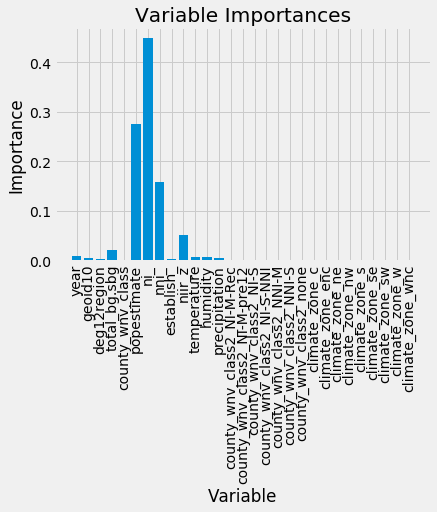

In [29]:
importances = list(rf.feature_importances_)

# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

Checking model performance:

In [30]:
# Calculate the absolute errors
errors = abs(predictions - test_labels)

In [31]:
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'IR units')

Mean Absolute Error: 0.04 IR units


In [32]:
print('R2 value: ', r2_score(test_labels, predictions))

R2 value:  0.8857593059655094


In [33]:
print ('Mean Squared Error: ', mean_squared_error(test_labels, predictions))

Mean Squared Error:  0.2502310768119116


In [34]:
# Calculate mean absolute percentage error (MAPE)
np.seterr(divide='ignore', invalid='ignore')
mape = 100 * (errors / test_labels)

In [35]:
# Calculate and display accuracy
accuracy = 100 - np.mean(mape[np.isfinite(mape)])
#accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 96.22 %.


In [36]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]

In [37]:
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')

In [38]:
# Write graph to a png file
graph.write_png('tree.png')

### RF Model No.2 : Creating a model with only 3 levels to generate a smaller image for understanding (Not exluding any columns)

In [39]:
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(train_features, train_labels)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

### RF Model No.3 : Creating a model with only the two most important variables - "ni_" and "popestimate" (Only 2 columns)

In [40]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)
# Extract the two most important features
important_indices = [feature_list.index('ni_'), feature_list.index('popestimate')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]
# Train the random forest
rf_most_important.fit(train_important, train_labels)
# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - test_labels)
# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'IR units.')

Mean Absolute Error: 0.03 IR units.


In [41]:
np.seterr(divide='ignore', invalid='ignore')
mape = 100 * (errors / test_labels)
accuracy = 100 - np.mean(mape[np.isfinite(mape)])
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 97.7 %.


### RF Model No.4 : Creating a model with only the columns for which the data can be acquired for future

Columns dropped:
> deg12region, total_bg.sbg, county_wnv_class, County classes, Climate classes - Same across all years for all counties

> ni_, nni_, niir_z - No future data available

In [42]:
wnv2 = wnv_one[['year', 'geoid10', 'ni_ir_','popestimate', 'establish_','temperature', 'humidity', 'precipitation']]
wnv2.columns

Index(['year', 'geoid10', 'ni_ir_', 'popestimate', 'establish_', 'temperature',
       'humidity', 'precipitation'],
      dtype='object')

In [43]:
# Labels are the values we want to predict
labels2 = np.array(wnv2['ni_ir_'])

In [44]:
# Remove the labels from the features
# axis 1 refers to the columns
features2 = wnv2.drop('ni_ir_', axis = 1)

# Saving feature names for later use
feature_list2 = list(features2.columns)
print("Feature list:\n\n", feature_list2)

Feature list:

 ['year', 'geoid10', 'popestimate', 'establish_', 'temperature', 'humidity', 'precipitation']


In [45]:
# Convert dataframe to numpy array
features2 = np.array(features2)
print("The shape of features is:\t", features2.shape)

The shape of features is:	 (14484, 7)


In [46]:
#Setting the random state to 42 which means the results will be the same each time we run the split 
#for reproducible results

train_features2, test_features2, train_labels2, test_labels2 = train_test_split(features2, labels2, 
                                                                            test_size = 0.25, random_state = 42)

In [47]:
print('Training Features Shape:', train_features2.shape)
print('Training Labels Shape:', train_labels2.shape)
print('Testing Features Shape:', test_features2.shape)
print('Testing Labels Shape:', test_labels2.shape)

Training Features Shape: (10863, 7)
Training Labels Shape: (10863,)
Testing Features Shape: (3621, 7)
Testing Labels Shape: (3621,)


In [48]:
#Instantiating model with 1000 decision trees
rf2 = RandomForestRegressor(n_estimators = 1000, random_state = 42)

In [49]:
start2 = time.process_time() #To calculate the time taken to train the model

# Train the model on training data
rf2.fit(train_features2, train_labels2)

print("Model trained in ", time.process_time() - start2, "seconds")

Model trained in  75.21683999999999 seconds


In [50]:
# Use the forest's predict method on the test data
predictions2 = rf2.predict(test_features2)

In [51]:
importances2 = list(rf2.feature_importances_)

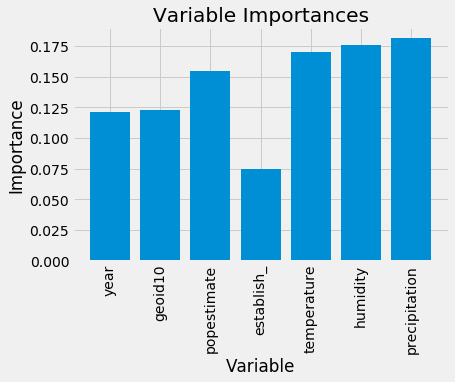

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values2 = list(range(len(importances2)))
# Make a bar chart
plt.bar(x_values2, importances2, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values2, feature_list2, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [84]:
feature_importances2 = pd.DataFrame(rf2.feature_importances_,
                                   index = feature_list2,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances2

,importance
precipitation,0.181078
humidity,0.175317
temperature,0.169992
popestimate,0.154374
geoid10,0.122929
year,0.121317
establish_,0.074994


In [53]:
# Calculate the absolute errors
errors2 = abs(predictions2 - test_labels2)

In [54]:
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors2), 2), 'IR units')

Mean Absolute Error: 0.42 IR units


In [55]:
print('R2 value: ', r2_score(test_labels2, predictions2))

R2 value:  0.22607415897387007


In [56]:
print ('Mean Squared Error: ', mean_squared_error(test_labels2, predictions2))

Mean Squared Error:  1.6951953785755587


### RF Model No.5 : Creating a model by integrating racial data with current weather data (Socio-economic data is not yet included)

In [57]:
rc = pd.read_csv('race_data.csv')

In [58]:
print(rc.columns)
print("\nShape: ", rc.shape)
print("\nYears: ", rc.YEAR.unique())
print("\nCounties: ", len(rc.STCOU.unique()))
rc.head(5)

Index(['YEAR', 'Areaname', 'STCOU', 'Resident_population_White_alone',
       'Resident_population_White_alone_percent',
       'Resident_population_Black_alone',
       'Resident_population_Black_alone_percent',
       'Resident_population_American_Indian_and_Alaska_Native_alone',
       'Resident_population_American_Indian_and_Alaska_Native_alone_percent',
       'Resident_population_Asian_alone',
       'Resident_population_Asian_alone_percent',
       'Resident_population_Native_Hawaiian_and_Other_Pacific_Islander_alone',
       'Resident_population_Native_Hawaiian_and_Other_Pacific_Islander_alone_percent',
       'Resident_population_Two_or_more_races',
       'Resident_population_Two_or_more_races_percent',
       'Resident_population_Hispanic_or_Latino_Origin',
       'Resident_population_Hispanic_or_Latino_Origin_percent',
       'Resident_population_Not_Hispanic_White_alone',
       'Resident_population_Not_Hispanic_White_alone_percent'],
      dtype='object')

Shape:  (31980,

,YEAR,Areaname,STCOU,Resident_population_White_alone,Resident_population_White_alone_percent,Resident_population_Black_alone,Resident_population_Black_alone_percent,Resident_population_American_Indian_and_Alaska_Native_alone,Resident_population_American_Indian_and_Alaska_Native_alone_percent,Resident_population_Asian_alone,Resident_population_Asian_alone_percent,Resident_population_Native_Hawaiian_and_Other_Pacific_Islander_alone,Resident_population_Native_Hawaiian_and_Other_Pacific_Islander_alone_percent,Resident_population_Two_or_more_races,Resident_population_Two_or_more_races_percent,Resident_population_Hispanic_or_Latino_Origin,Resident_population_Hispanic_or_Latino_Origin_percent,Resident_population_Not_Hispanic_White_alone,Resident_population_Not_Hispanic_White_alone_percent
0,2000,UNITED STATES,0,228602436,81.000000,35807824,12.700000,2675900,0.900000,10687312,3.800000,465614,0.200000,3932871,1.400000,35642379,12.600000,195762792,69.400000
1,2000,ALABAMA,1000,3197029,71.800000,1161485,26.100000,23038,0.500000,32446,0.700000,1531,0.000000,36320,0.800000,76504,1.700000,3131423,70.300000
2,2000,"Autauga, AL",1001,35549,81.000000,7558,17.200000,198,0.500000,204,0.500000,13,0.000000,350,0.800000,610,1.400000,35018,79.800000
3,2000,"Baldwin, AL",1003,124101,87.800000,14678,10.400000,823,0.600000,547,0.400000,38,0.000000,1171,0.800000,2486,1.800000,121868,86.200000
4,2000,"Barbour, AL",1005,15151,52.200000,13482,46.400000,131,0.500000,87,0.300000,9,0.000000,175,0.600000,478,1.600000,14783,50.900000


In [63]:
print("\nYears: ", wnv2.year.unique())
wnv2.head(5)


Years:  [1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012
 2013 2014 2015]


,year,geoid10,ni_ir_,popestimate,establish_,temperature,humidity,precipitation
0,1999,1001,0.000000,42963.000000,0,291.518659,73.042486,3.560286
1,1999,1003,0.000000,137555.000000,0,294.361160,75.947582,3.225454
2,1999,1015,0.000000,114910.000000,0,290.075280,72.004987,3.033717
3,1999,1033,0.000000,54715.000000,0,290.192782,72.069193,2.872019
4,1999,1045,0.000000,49118.000000,0,292.766317,72.045064,3.138175


In [65]:
wnv3 = pd.merge(wnv2, rc,  how='inner', left_on=['year','geoid10'], right_on = ['YEAR','STCOU'])
print(wnv3.columns)
print("\nShape: ", wnv3.shape)
print("\nYears: ", wnv3.YEAR.unique())
print("\nCounties: ", len(wnv3.STCOU.unique()))
wnv3.head(5)

Index(['year', 'geoid10', 'ni_ir_', 'popestimate', 'establish_', 'temperature',
       'humidity', 'precipitation', 'YEAR', 'Areaname', 'STCOU',
       'Resident_population_White_alone',
       'Resident_population_White_alone_percent',
       'Resident_population_Black_alone',
       'Resident_population_Black_alone_percent',
       'Resident_population_American_Indian_and_Alaska_Native_alone',
       'Resident_population_American_Indian_and_Alaska_Native_alone_percent',
       'Resident_population_Asian_alone',
       'Resident_population_Asian_alone_percent',
       'Resident_population_Native_Hawaiian_and_Other_Pacific_Islander_alone',
       'Resident_population_Native_Hawaiian_and_Other_Pacific_Islander_alone_percent',
       'Resident_population_Two_or_more_races',
       'Resident_population_Two_or_more_races_percent',
       'Resident_population_Hispanic_or_Latino_Origin',
       'Resident_population_Hispanic_or_Latino_Origin_percent',
       'Resident_population_Not_Hispanic_

,year,geoid10,ni_ir_,popestimate,establish_,temperature,humidity,precipitation,YEAR,Areaname,...,Resident_population_Asian_alone,Resident_population_Asian_alone_percent,Resident_population_Native_Hawaiian_and_Other_Pacific_Islander_alone,Resident_population_Native_Hawaiian_and_Other_Pacific_Islander_alone_percent,Resident_population_Two_or_more_races,Resident_population_Two_or_more_races_percent,Resident_population_Hispanic_or_Latino_Origin,Resident_population_Hispanic_or_Latino_Origin_percent,Resident_population_Not_Hispanic_White_alone,Resident_population_Not_Hispanic_White_alone_percent
0,2000,1001,0.000000,44021.000000,0,292.016556,68.767568,2.709550,2000,"Autauga, AL",...,204,0.500000,13,0.000000,350,0.800000,610,1.400000,35018,79.800000
1,2000,1003,0.000000,141342.000000,0,294.992369,73.640684,2.507449,2000,"Baldwin, AL",...,547,0.400000,38,0.000000,1171,0.800000,2486,1.800000,121868,86.200000
2,2000,1015,0.000000,111081.000000,0,291.116250,66.668711,2.274747,2000,"Calhoun, AL",...,656,0.600000,79,0.100000,904,0.800000,1751,1.600000,86919,78.100000
3,2000,1033,0.000000,54997.000000,0,290.819087,67.699906,2.730965,2000,"Colbert, AL",...,135,0.200000,13,0.000000,429,0.800000,618,1.100000,44515,80.900000
4,2000,1045,0.000000,49124.000000,0,293.179896,68.683388,2.566736,2000,"Dale, AL",...,555,1.100000,82,0.200000,849,1.700000,1644,3.400000,35808,73.000000


In [66]:
wnv3 = wnv3.drop(['YEAR', 'Areaname', 'STCOU'], axis = 1) 
wnv3.shape

(8520, 24)

In [67]:
# Labels are the values we want to predict
labels3 = np.array(wnv3['ni_ir_'])

In [68]:
# Remove the labels from the features
# axis 1 refers to the columns
features3 = wnv3.drop('ni_ir_', axis = 1)

# Saving feature names for later use
feature_list3 = list(features3.columns)
print("Feature list:\n\n", feature_list3)

Feature list:

 ['year', 'geoid10', 'popestimate', 'establish_', 'temperature', 'humidity', 'precipitation', 'Resident_population_White_alone', 'Resident_population_White_alone_percent', 'Resident_population_Black_alone', 'Resident_population_Black_alone_percent', 'Resident_population_American_Indian_and_Alaska_Native_alone', 'Resident_population_American_Indian_and_Alaska_Native_alone_percent', 'Resident_population_Asian_alone', 'Resident_population_Asian_alone_percent', 'Resident_population_Native_Hawaiian_and_Other_Pacific_Islander_alone', 'Resident_population_Native_Hawaiian_and_Other_Pacific_Islander_alone_percent', 'Resident_population_Two_or_more_races', 'Resident_population_Two_or_more_races_percent', 'Resident_population_Hispanic_or_Latino_Origin', 'Resident_population_Hispanic_or_Latino_Origin_percent', 'Resident_population_Not_Hispanic_White_alone', 'Resident_population_Not_Hispanic_White_alone_percent']


In [69]:
# Convert dataframe to numpy array
features3 = np.array(features3)
print("The shape of features is:\t", features3.shape)

The shape of features is:	 (8520, 23)


In [70]:
#Setting the random state to 42 which means the results will be the same each time we run the split 
#for reproducible results

train_features3, test_features3, train_labels3, test_labels3 = train_test_split(features3, labels3, 
                                                                            test_size = 0.25, random_state = 42)

In [71]:
print('Training Features Shape:', train_features3.shape)
print('Training Labels Shape:', train_labels3.shape)
print('Testing Features Shape:', test_features3.shape)
print('Testing Labels Shape:', test_labels3.shape)

Training Features Shape: (6390, 23)
Training Labels Shape: (6390,)
Testing Features Shape: (2130, 23)
Testing Labels Shape: (2130,)


In [72]:
#Instantiating model with 1000 decision trees
rf3 = RandomForestRegressor(n_estimators = 1000, random_state = 42)

In [73]:
start3 = time.process_time() #To calculate the time taken to train the model

# Train the model on training data
rf3.fit(train_features3, train_labels3)

print("Model trained in ", time.process_time() - start3, "seconds")

Model trained in  143.655438 seconds


In [74]:
# Use the forest's predict method on the test data
predictions3 = rf3.predict(test_features3)

In [75]:
# Calculate the absolute errors
errors3 = abs(predictions3 - test_labels3)

In [76]:
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors3), 2), 'IR units')

Mean Absolute Error: 0.5 IR units


In [77]:
print('R2 value: ', r2_score(test_labels3, predictions3))

R2 value:  0.14647768336838207


In [78]:
print ('Mean Squared Error: ', mean_squared_error(test_labels3, predictions3))

Mean Squared Error:  2.454028188982675


In [80]:
importances3 = list(rf3.feature_importances_)

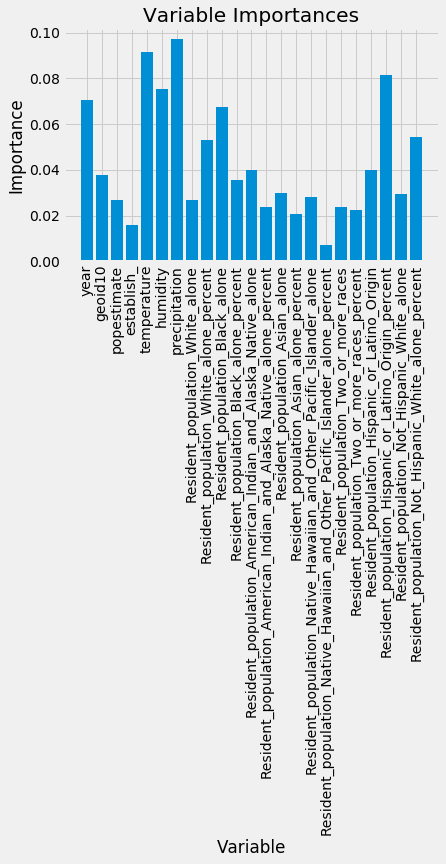

In [81]:
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values3 = list(range(len(importances3)))
# Make a bar chart
plt.bar(x_values3, importances3, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values3, feature_list3, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [85]:
feature_importances3 = pd.DataFrame(rf3.feature_importances_,
                                   index = feature_list3,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances3

,importance
precipitation,0.097105
temperature,0.091321
Resident_population_Hispanic_or_Latino_Origin_percent,0.081418
humidity,0.075561
year,0.070733
Resident_population_Black_alone,0.067617
Resident_population_Not_Hispanic_White_alone_percent,0.054494
Resident_population_White_alone_percent,0.053054
Resident_population_Hispanic_or_Latino_Origin,0.040038
Resident_population_American_Indian_and_Alaska_Native_alone,0.039872


### RF Model No.6 : WNV data (+ Weather) + Socio-economic data (Race data not included)

In [86]:
se = pd.read_csv('se_data.csv') #The Socio-Economic data that was cleaned by Vinu

In [87]:
print(se.columns)
print("\nShape: ", se.shape)
print("\nYears: ", se.YEAR.unique())
print("\nCounties: ", len(se.STCOU.unique()))
se.head(5)

Index(['YEAR', 'Areaname', 'STCOU', 'Median_Household_Income',
       'Poverty_number_of_people', 'Poverty_percent_of_people',
       'Public_school_enrollment_Fall'],
      dtype='object')

Shape:  (44772, 7)

Years:  [1995 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009]

Counties:  3198


,YEAR,Areaname,STCOU,Median_Household_Income,Poverty_number_of_people,Poverty_percent_of_people,Public_school_enrollment_Fall
0,1995,UNITED STATES,0,34076,36424609,13.800000,43369917
1,1995,ALABAMA,1000,27357,752097,17.600000,730509
2,1995,"Autauga, AL",1001,34842,5471,13.400000,7381
3,1995,"Baldwin, AL",1003,35014,15494,12.400000,19384
4,1995,"Barbour, AL",1005,24423,6423,24.900000,5111


In [88]:
print("\nYears: ", wnv2.year.unique())
wnv2.head(5)


Years:  [1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012
 2013 2014 2015]


,year,geoid10,ni_ir_,popestimate,establish_,temperature,humidity,precipitation
0,1999,1001,0.000000,42963.000000,0,291.518659,73.042486,3.560286
1,1999,1003,0.000000,137555.000000,0,294.361160,75.947582,3.225454
2,1999,1015,0.000000,114910.000000,0,290.075280,72.004987,3.033717
3,1999,1033,0.000000,54715.000000,0,290.192782,72.069193,2.872019
4,1999,1045,0.000000,49118.000000,0,292.766317,72.045064,3.138175


In [90]:
wnv4 = pd.merge(wnv2, se,  how='inner', left_on=['year','geoid10'], right_on = ['YEAR','STCOU'])
print(wnv4.columns)
print("\nShape: ", wnv4.shape)
print("\nYears: ", wnv4.YEAR.unique())
print("\nCounties: ", len(wnv4.STCOU.unique()))
wnv4.head(5)

Index(['year', 'geoid10', 'ni_ir_', 'popestimate', 'establish_', 'temperature',
       'humidity', 'precipitation', 'YEAR', 'Areaname', 'STCOU',
       'Median_Household_Income', 'Poverty_number_of_people',
       'Poverty_percent_of_people', 'Public_school_enrollment_Fall'],
      dtype='object')

Shape:  (9372, 15)

Years:  [1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009]

Counties:  852


,year,geoid10,ni_ir_,popestimate,establish_,temperature,humidity,precipitation,YEAR,Areaname,STCOU,Median_Household_Income,Poverty_number_of_people,Poverty_percent_of_people,Public_school_enrollment_Fall
0,1999,1001,0.000000,42963.000000,0,291.518659,73.042486,3.560286,1999,"Autauga, AL",1001,39702,4991,11.400000,8211
1,1999,1003,0.000000,137555.000000,0,294.361160,75.947582,3.225454,1999,"Baldwin, AL",1003,39194,14668,10.500000,21771
2,1999,1015,0.000000,114910.000000,0,290.075280,72.004987,3.033717,1999,"Calhoun, AL",1015,31389,18035,16.300000,19565
3,1999,1033,0.000000,54715.000000,0,290.192782,72.069193,2.872019,1999,"Colbert, AL",1033,31930,7430,13.600000,8701
4,1999,1045,0.000000,49118.000000,0,292.766317,72.045064,3.138175,1999,"Dale, AL",1045,31267,7830,16.400000,7761


In [92]:
wnv4 = wnv4.drop(['YEAR', 'Areaname', 'STCOU'], axis = 1) 
wnv4.shape

(9372, 12)

In [97]:
# Labels are the values we want to predict
labels4 = np.array(wnv4['ni_ir_'])

In [98]:
# Remove the labels from the features
# axis 1 refers to the columns
features4 = wnv4.drop('ni_ir_', axis = 1)

# Saving feature names for later use
feature_list4 = list(features4.columns)
print("Feature list:\n\n", feature_list4)

Feature list:

 ['year', 'geoid10', 'popestimate', 'establish_', 'temperature', 'humidity', 'precipitation', 'Median_Household_Income', 'Poverty_number_of_people', 'Poverty_percent_of_people', 'Public_school_enrollment_Fall']


In [99]:
# Convert dataframe to numpy array
features4 = np.array(features4)
print("The shape of features is:\t", features4.shape)

The shape of features is:	 (9372, 11)


In [100]:
#Setting the random state to 42 which means the results will be the same each time we run the split 
#for reproducible results

train_features4, test_features4, train_labels4, test_labels4 = train_test_split(features4, labels4, 
                                                                            test_size = 0.25, random_state = 42)

In [101]:
print('Training Features Shape:', train_features4.shape)
print('Training Labels Shape:', train_labels4.shape)
print('Testing Features Shape:', test_features4.shape)
print('Testing Labels Shape:', test_labels4.shape)

Training Features Shape: (7029, 11)
Training Labels Shape: (7029,)
Testing Features Shape: (2343, 11)
Testing Labels Shape: (2343,)


In [105]:
#Instantiating model with 1000 decision trees
rf4 = RandomForestRegressor(n_estimators = 1000, random_state = 42)

In [106]:
start4 = time.process_time() #To calculate the time taken to train the model

# Train the model on training data
rf4.fit(train_features4, train_labels4)

print("Model trained in ", time.process_time() - start4, "seconds")

Model trained in  73.98408200000006 seconds


In [107]:
# Use the forest's predict method on the test data
predictions4 = rf4.predict(test_features4)

In [108]:
# Calculate the absolute errors
errors4 = abs(predictions4 - test_labels4)

In [109]:
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors4), 2), 'IR units')

Mean Absolute Error: 0.44 IR units


In [110]:
print('R2 value: ', r2_score(test_labels4, predictions4))

R2 value:  0.2443347169454021


In [111]:
print ('Mean Squared Error: ', mean_squared_error(test_labels4, predictions4))

Mean Squared Error:  2.288592416059289


In [112]:
importances4 = list(rf4.feature_importances_)

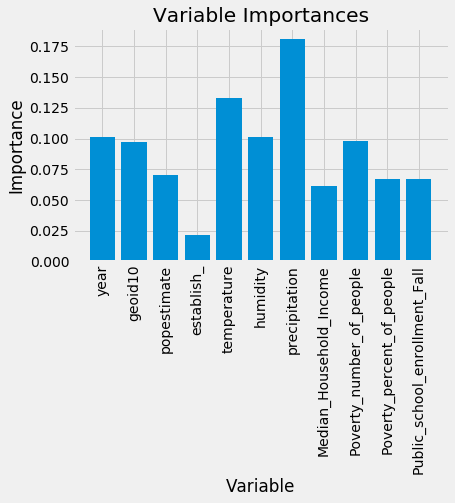

In [113]:
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values4 = list(range(len(importances4)))
# Make a bar chart
plt.bar(x_values4, importances4, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values4, feature_list4, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [114]:
feature_importances4 = pd.DataFrame(rf4.feature_importances_,
                                   index = feature_list4,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances4

,importance
precipitation,0.180721
temperature,0.133056
year,0.101545
humidity,0.101398
Poverty_number_of_people,0.097594
geoid10,0.097472
popestimate,0.070574
Poverty_percent_of_people,0.067439
Public_school_enrollment_Fall,0.067154
Median_Household_Income,0.061428
